In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE
from sdebridge.utils import *

plt.style.use('ggplot')
rng = jax.random.PRNGKey(0)

## 1 Dimensional

In [3]:
sde_params = {
    "dimension": 1,
    "num_steps": 200,
}
sde = BrownianSDE(sde_params)
bridge = DiffusionBridge(sde=sde)

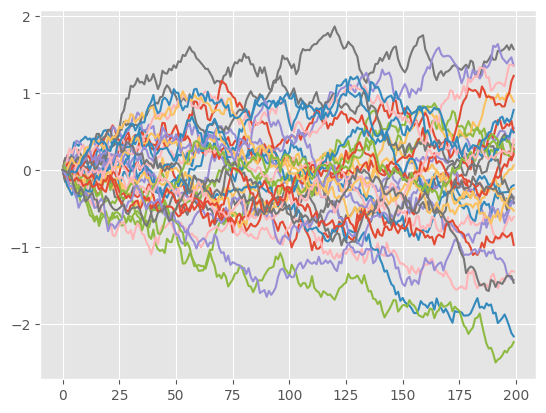

In [4]:
X0 = jnp.array([0.0])
XT = jnp.array([1.0])
forward_brownian_motion = bridge.simulate_forward_process(initial_val=X0,
                                                          rng=rng,
                                                          num_batches=64)
for i in range(32):
    plt.plot(forward_brownian_motion["trajectories"][i, :, 0])

In [5]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 20/20 [00:05<00:00,  3.36epoch/s, Epoch=20, loss=0.4846]


In [8]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=Partial(eval_score, state=score_p_state),
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 20/20 [00:06<00:00,  3.23epoch/s, Epoch=20, loss=0.4748]


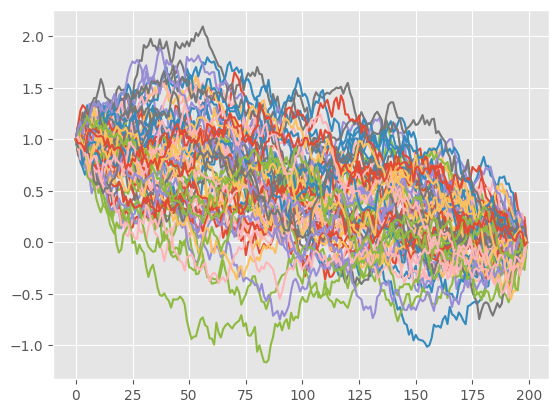

In [9]:
score_p = Partial(lambda val, time, score_p_state: eval_score(score_p_state, val, time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=64)
for i in range(64):
    plt.plot(backward_brownian_bridge["trajectories"][i, :, 0])

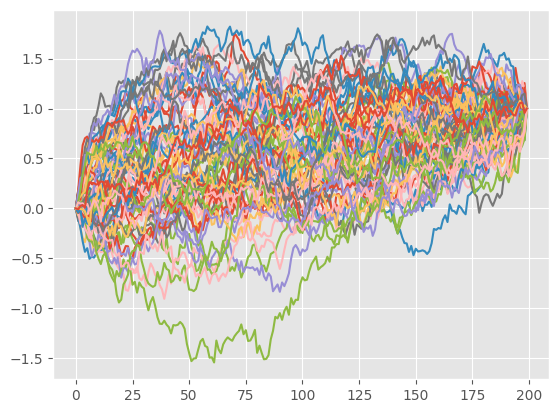

In [12]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=64)
for i in range(64):
    plt.plot(forward_brownian_bridge["trajectories"][i, :, 0])

## 2 Dimensional

### Learn the transition density of $X_t$

In [23]:
sde_params = {
    "dimension": 2,
    "num_steps": 100,
}
sde = BrownianSDE(sde_params)
bridge = DiffusionBridge(sde=sde)

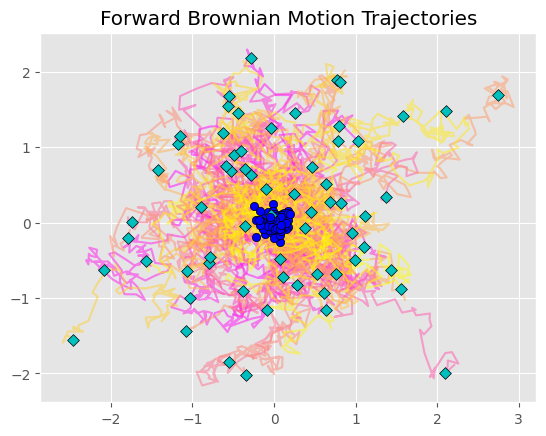

In [24]:
X0 = jnp.array([[0.0, 0.0]])
XT = jnp.array([[2.0, 0.0]])
forward_brownian_motion = bridge.simulate_forward_process(initial_val=X0, 
                                                          rng=rng,
                                                          num_batches=64)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [25]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 50/50 [00:13<00:00,  3.61epoch/s, Epoch=50, loss=0.9413]


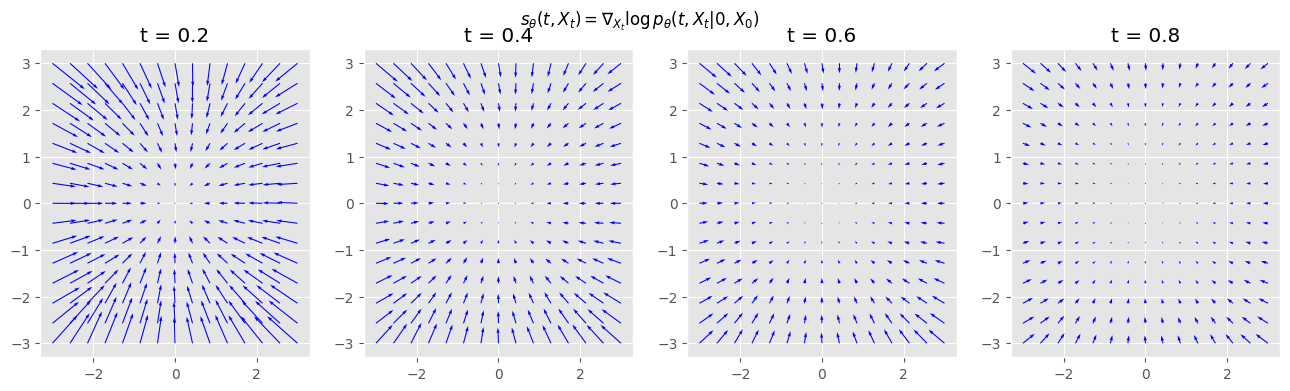

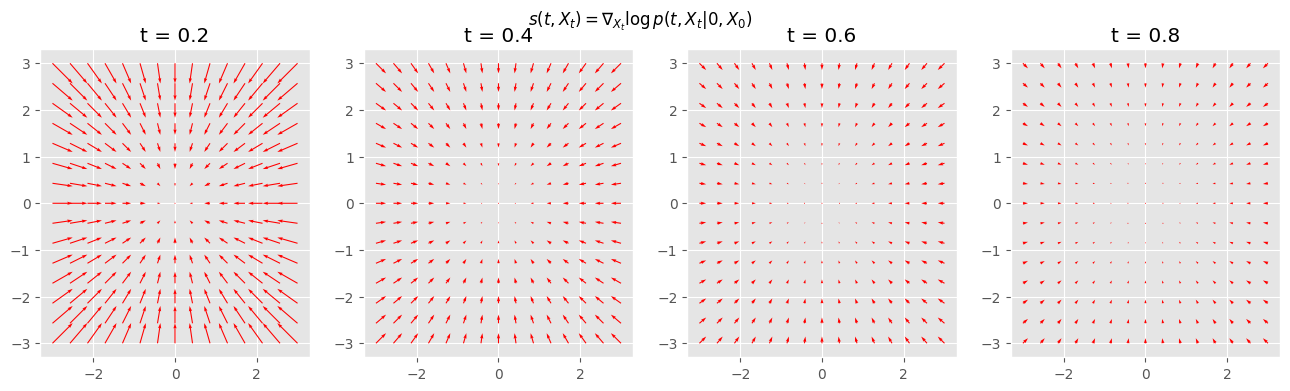

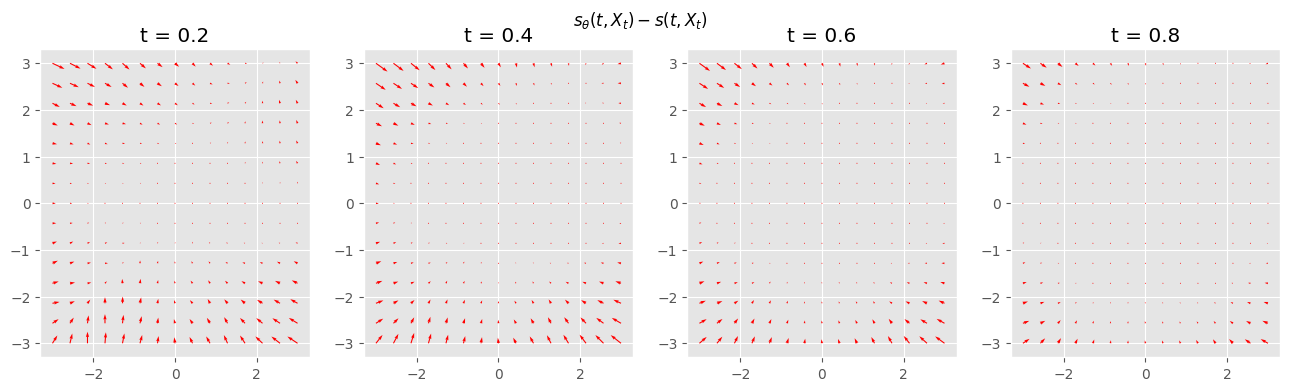

In [26]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=X0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_p_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=X0)

### Use learned transition score to simulate the backward bridge

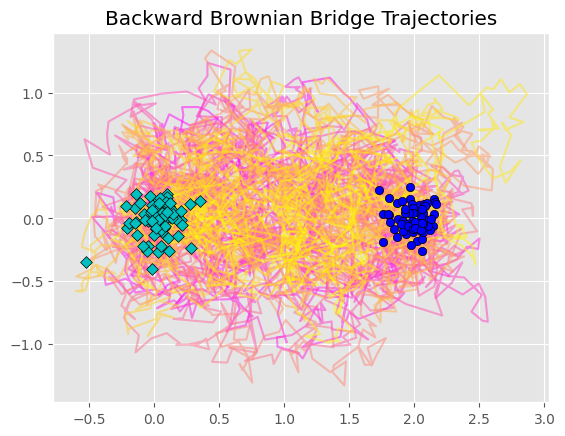

In [27]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=64)
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [28]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 50/50 [00:14<00:00,  3.44epoch/s, Epoch=50, loss=0.8979]


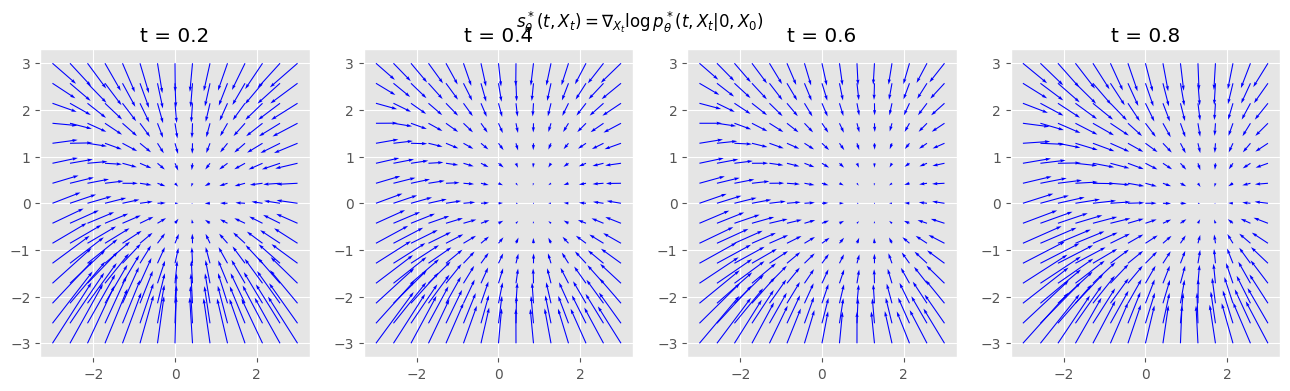

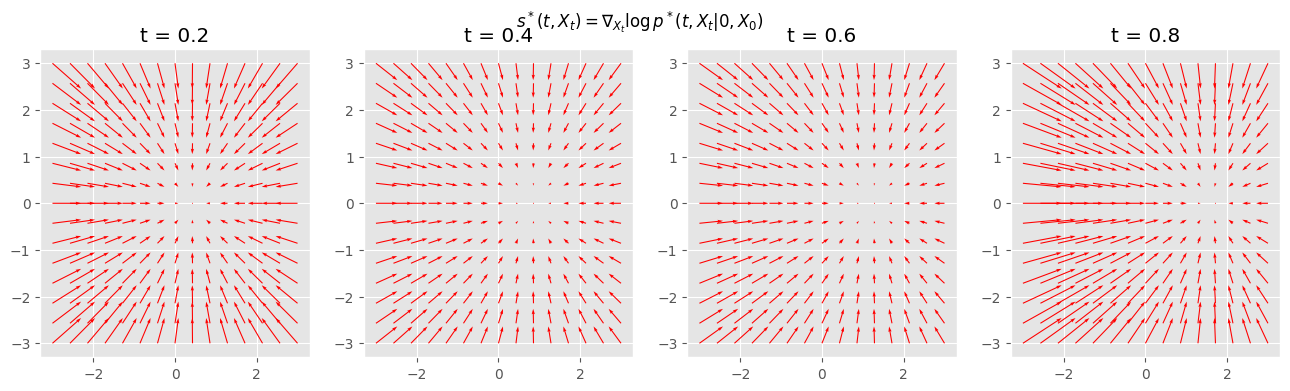

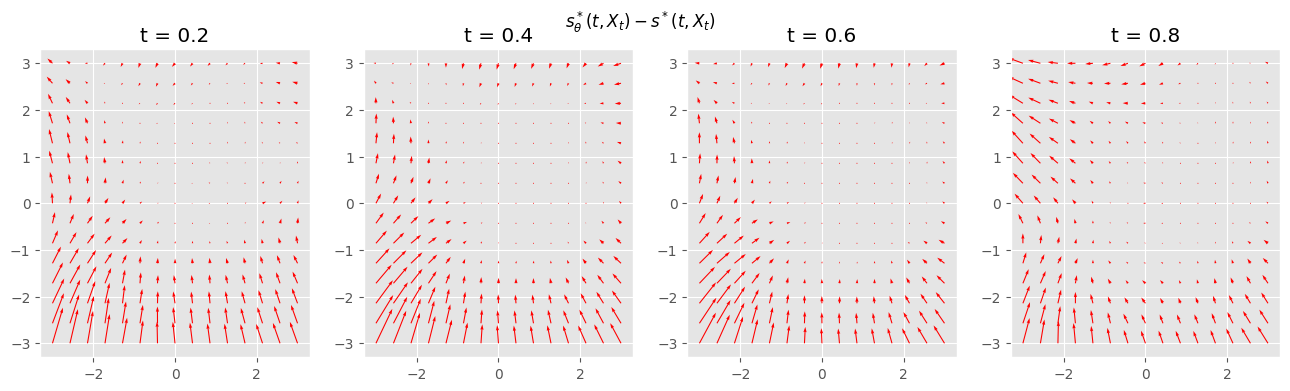

In [29]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_star_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: -(x-xT) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 0.0]),
                     scale=200,
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_p_star_state, x, t) + (x-xT) / (T-t) + (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([2.0, 0.0]),
                     T=1.0)

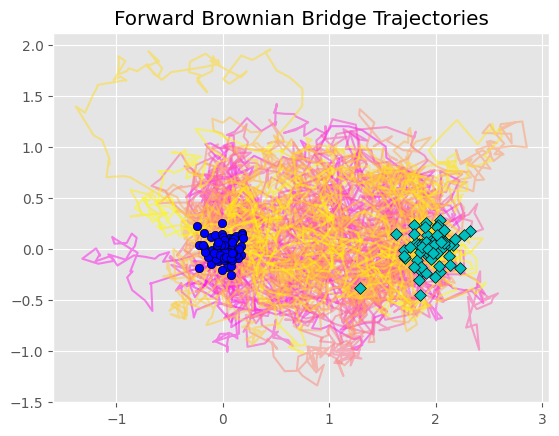

In [30]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=64)
plot_2d_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [31]:
sde_params = {
    "dimension": 64,
    "num_steps": 100,
}
sde = BrownianSDE(sde_params)
bridge = DiffusionBridge(sde=sde)

(64,) (64,)


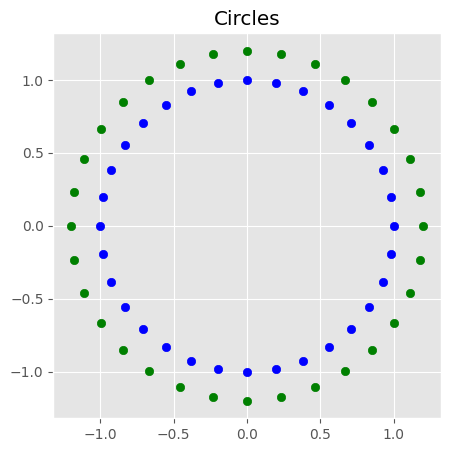

In [33]:
num_points = sde_params["dimension"] // 2
circle1 = sample_circle(num_points=num_points, scale=1.0, shifts=jnp.array([0.0, 0.0]))
circle2 = sample_circle(num_points=num_points, scale=1.2, shifts=jnp.array([0.0, 0.0]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(circle1.reshape(-1, 2)[:, 0], circle1.reshape(-1, 2)[:, 1], color='b')
ax.scatter(circle2.reshape(-1, 2)[:, 0], circle2.reshape(-1, 2)[:, 1], color='g')
ax.set_title("Circles")
print(circle1.shape, circle2.shape)

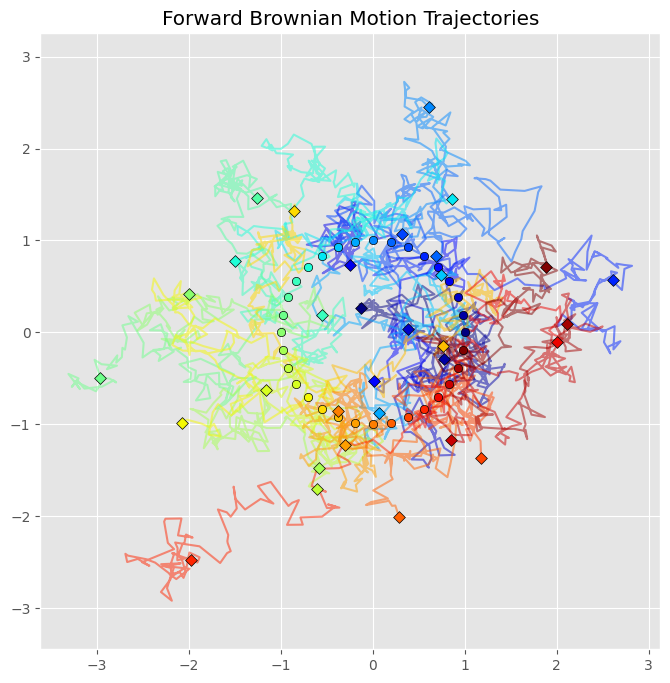

In [34]:
X0 = circle1
XT = circle2
forward_brownian_motion = bridge.simulate_forward_process(initial_val=X0, 
                                                          rng=rng,
                                                          num_batches=1)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion Trajectories")

In [36]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 256, 256],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params,
                                     rng=rng,
                                     loss_calibration=False)

Training: 100%|██████████| 30/30 [06:44<00:00, 13.49s/epoch, Epoch=30, loss=30.7112]


In [39]:
score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p,
                                                           rng=rng,
                                                           num_batches=16)

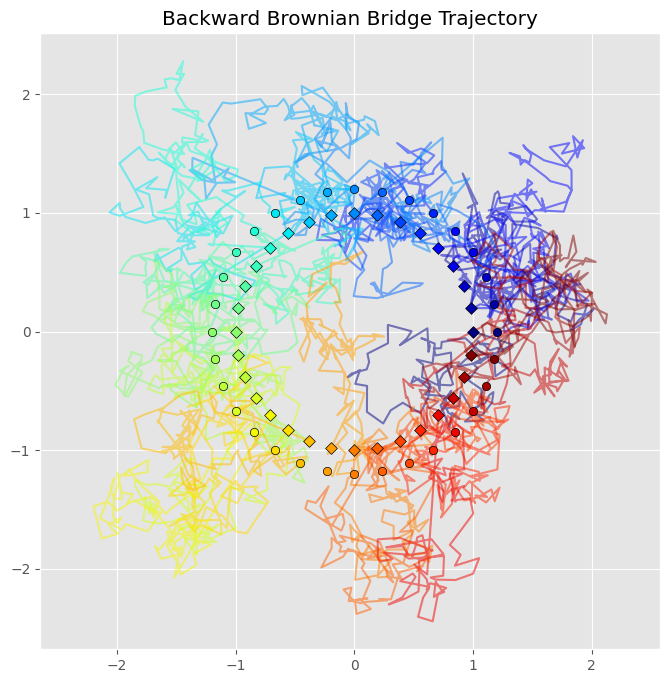

In [43]:
plot_single_trajectory(backward_brownian_bridge["trajectories"][0], title="Backward Brownian Bridge Trajectory")

In [44]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 128,
                "encoding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 256, 256],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng,
                                               loss_calibration=False)

Training: 100%|██████████| 30/30 [09:28<00:00, 18.96s/epoch, Epoch=30, loss=29.7841]


In [45]:
score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h,
                                                         rng=rng,
                                                         num_batches=16)

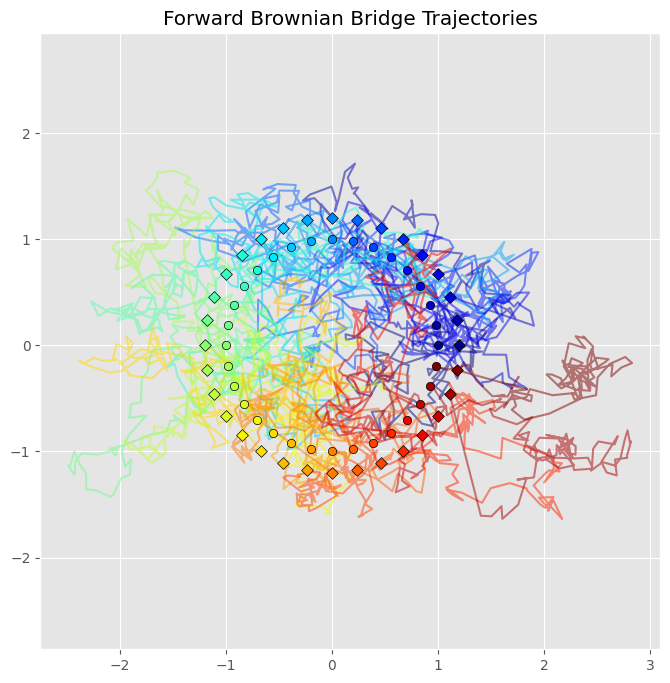

In [47]:
plot_single_trajectory(forward_brownian_bridge["trajectories"][4], title="Forward Brownian Bridge Trajectories")